# Price Simulation

We have a few ways for generating prices.

### Collateral Prices

We simulate collateral prices (e.g. WETH) as correlated GBMs. We estimate the generative GBM parameters using historical data from Coingecko (see `scripts/gen_price_config.py`).

### Stablecoin Prices

We simulate stablecoin prices (e.g. USDC) as correlated Ornstein-Uhlenbeck (OU) processes. These are simply mean-reverting GBMs. We similarly estimate the generative OU parameters using a Maximum Likelihood Estimator (MLE) on historical Coingecko data (see `src/prices/utils.py`).

## Shocks

We apply three kinds of shocks in different scenarios:

1. Drift-shock: we may shock the drift parameter of the collateral GBMs. This allows us to control the expected returns per-timestep. For example, the baseline scenarios will shock the drift by setting it to 0. See `src/sim/scenarios/baseline/__init__.py`.
2. Volatility-shock: we may shock the volatility parameter of the collateral or stablecoin processes. This allows us to enforce higher price volatility in our simulations.
3. Jumps.

We will dive deeper into jumps in this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.sim.scenario import Scenario
from src.prices.utils import get_factor, gen_cor_prices, get_gran
from datetime import datetime
import pandas as pd
import requests as req
from src.plotting.utils import make_square
from src.plotting import plot_prices
from src.configs import get_price_config
from src.configs.tokens import WETH, WSTETH, SFRXETH, WBTC, TBTC, USDC

plt.rcParams["axes.spines.right"] = True

%load_ext autoreload
%autoreload 2

# Estimating Stressed Drift and Volatility

Our stress scenarios consider stressed drift and volatility parameters for simulating collateral prices. We calculate the stress variables as follows:

### Stressed Volatility

We take the p99 standard deviation of log returns. 

More specifically, we fetch hourly price data from Jan20 to Jan24. We resample this data at the simulation frequency (5min). We then compute the log returns of our data. From these 5min log returns, we compute the intraday volatility for the asset as the standard deviation of log returns in a 1 day rolling window.

We assume that wstETH and sfrxETH have similar stressed volatilities to ETH (we have much more data on ETH price volatility!)

In [32]:
# Fetch prices from cryptocompare (more granular than CoinGecko)
url = "https://min-api.cryptocompare.com/data/v2/histohour"
params = {
    "tsym": "USD",
    "limit": 2000,
}


def fetch(sym, end=None):
    if end:
        params["toTs"] = end
    params["fsym"] = sym
    res = req.get(url, params=params)
    data = res.json()["Data"]
    start = data["TimeFrom"]
    df = pd.DataFrame(data["Data"])
    df.set_index(pd.to_datetime(df["time"], unit="s"), inplace=True)
    df = df["close"]
    return df, start


def fetch_all(sym, start, freq):
    dfs = []
    ts = datetime.now().timestamp()
    while ts > start:
        df, ts = fetch(sym, ts)
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_index(inplace=True)
    df = df.resample(freq).last().interpolate()
    return pd.DataFrame(df)


def get_rolling_std(df, freq, window):
    annual_factor = get_factor(freq)
    col = "close"
    df[f"{col}_returns"] = df[col].pct_change()
    df[f"{col}_log_returns"] = np.log1p(df[f"{col}_returns"])
    rolling_std = df[f"{col}_log_returns"].rolling(window).std() * np.sqrt(
        annual_factor
    )
    rolling_mu = df[f"{col}_log_returns"].rolling(window).mean() * annual_factor
    return rolling_std, rolling_mu


def calc_stressed_volatilites(syms, start, freq, window, plot=False):
    """
    Calculate the stressed volatilities for the input coins.
    Optionally plot.

    Data is hourly so freq must be hourly!
    """
    assert (
        freq == "1h"
    ), "Data is hourly so freq must be hourly! Results are annualized."
    stats = []

    if plot:
        # n, m = make_square(len(syms) * 2)
        n, m = make_square(len(syms))
        f, axs = plt.subplots(n, m, figsize=(10, 5))
        flat = axs.flatten()

    for i, sym in enumerate(syms):
        # Fetch and process data
        df = fetch_all(sym, start, freq)
        rolling_std, rolling_mu = get_rolling_std(df, freq, window)
        stats.append(
            {
                "symbol": sym,
                "vol_mean": rolling_std.mean(),
                # "vol_std": rolling_std.std(),
                "vol_median": rolling_std.quantile(0.5),
                # "vol_p95": rolling_std.quantile(0.95),
                "vol_p99": rolling_std.quantile(0.99),
                "vol_max": rolling_std.max(),
                "mu_mean": rolling_mu.mean(),
                # "mu_std": rolling_mu.std(),
                "mu_median": rolling_mu.quantile(0.5),
                # "mu_p05": rolling_mu.quantile(0.05),
                "mu_p01": rolling_mu.quantile(0.01),
                "mu_min": rolling_mu.min(),
            }
        )

        if plot:
            ax1 = flat[i]
            # ax2 = flat[i + len(syms)]

            ax1.hist(rolling_std, bins=50, color="indianred")
            ax1.set_xlabel("Volatility")
            ax1.set_title(f"{sym} Intraday Volatility Histogram")

            # ax2.hist(rolling_mu, bins=50, color="indianred")
            # ax2.set_xlabel("Mu")
            # ax2.set_title(f"{sym} Intraday Mu Histogram")

    if plot:
        f.tight_layout()
        plt.savefig("../figs/misc/price_hist.png", dpi=300)
        plt.show()

    stats = pd.DataFrame(stats)
    stats.set_index("symbol", inplace=True)
    return stats

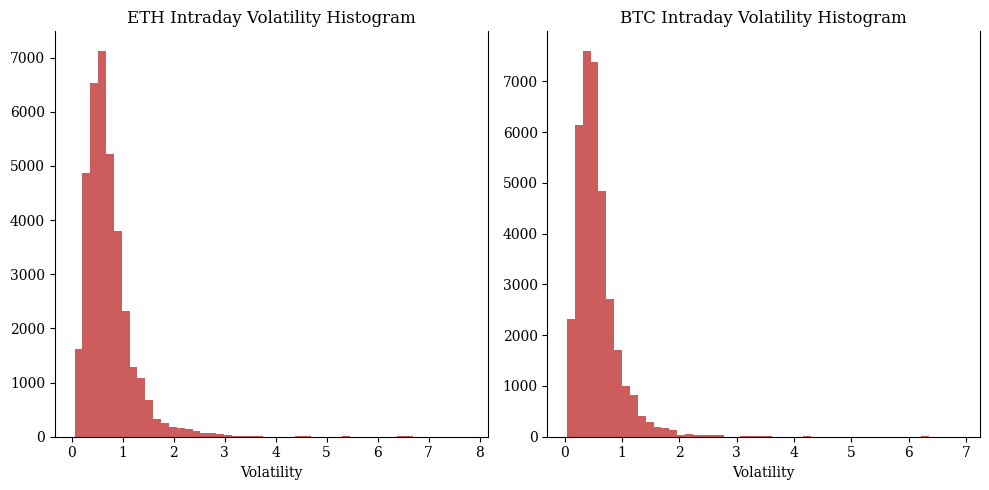

,vol_mean,vol_median,vol_p99,vol_max,mu_mean,mu_median,mu_p01,mu_min
symbol,,,,,,,,
ETH,0.718110,0.621363,2.458860,7.770689,0.694239,0.536653,-47.030258,0.051010
BTC,0.561555,0.485915,1.882229,6.899443,0.436965,0.350146,-37.011385,0.040334


In [33]:
freq = "1h"
window = "1d"
start = int(datetime(2020, 1, 1).timestamp())
stats = calc_stressed_volatilites(["ETH", "BTC"], start, freq, window, plot=True)
stats

In [35]:
stats[["vol_p99"]]

,vol_p99
symbol,
ETH,2.458860
BTC,1.882229


In [34]:
print(stats.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrr}
\toprule
 & vol_mean & vol_median & vol_p99 & vol_max & mu_mean & mu_median & mu_p01 & mu_min \\
symbol &  &  &  &  &  &  &  &  \\
\midrule
ETH & 0.72 & 0.62 & 2.46 & 7.77 & 0.69 & 0.54 & -47.03 & 0.05 \\
BTC & 0.56 & 0.49 & 1.88 & 6.90 & 0.44 & 0.35 & -37.01 & 0.04 \\
\bottomrule
\end{tabular}



In [43]:
vols = [
    ["WETH", "wstETH", "sfrxETH", "WBTC", "tBTC"],
    [0.460897, 0.449017, 0.469875, 0.425651, 0.449886],  # baseline
    [2.445831, 2.445831, 2.445831, 1.877968, 1.877968],  # adverse
    [3.6687465, 3.6687465, 3.6687465, 2.816952, 2.816952],  # severe
]

vols = pd.DataFrame(vols[1:], columns=vols[0])
vols.index = ["baseline", "adverse", "severe"]
print(vols.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & WETH & wstETH & sfrxETH & WBTC & tBTC \\
\midrule
baseline & 0.46 & 0.45 & 0.47 & 0.43 & 0.45 \\
adverse & 2.45 & 2.45 & 2.45 & 1.88 & 1.88 \\
severe & 3.67 & 3.67 & 3.67 & 2.82 & 2.82 \\
\bottomrule
\end{tabular}



In [ ]:
SHOCK_VOL_ADVERSE = {
    "target": {
        "WBTC": 1.877968,
        "tBTC": 1.877968,
        "WETH": 2.445831,
        "sfrxETH": 2.445831,
        "wstETH": 2.445831,
    },
    "type": VOL,
    "tag": ADVERSE,
    "description": "p99 intraday vol observed since 2020.",
}

SHOCK_VOL_SEVERE = {
    "target": {
        "WBTC": 2.816952,
        "tBTC": 2.816952,
        "WETH": 3.6687465,
        "sfrxETH": 3.6687465,
        "wstETH": 3.6687465,
    },
    "type": VOL,
    "tag": SEVERE,
    "description": "50% worse than the adverse scenario. This is massive volatility.",
}

In [37]:
from src.configs import get_price_config

cfg = get_price_config("5min", 1697068800, 1704585600)
params = pd.DataFrame(cfg["params"])

In [38]:
params

,usd-coin,tether,paxos-standard,true-usd,weth,wrapped-steth,staked-frax-ether,wrapped-bitcoin,tbtc
theta,10000.0,10000.0,10000.0,10000.0,NaN,NaN,NaN,NaN,NaN
mu,1.000039,1.000248,1.000119,0.999105,1.502133,1.532842,1.533481,2.062816,2.048619
sigma,30.042551,26.511676,41.971728,74.200943,0.460897,0.449017,0.469875,0.425651,0.449886
type,OU,OU,OU,OU,GBM,GBM,GBM,GBM,GBM


In [26]:
from src.configs import STABLE_CG_IDS

for col in params:
    if col not in STABLE_CG_IDS:
        params.loc["mu", col] = 0
params

,usd-coin,tether,paxos-standard,true-usd,weth,wrapped-steth,staked-frax-ether,wrapped-bitcoin,tbtc
theta,10000.0,10000.0,10000.0,10000.0,NaN,NaN,NaN,NaN,NaN
mu,1.000039,1.000248,1.000119,0.999105,0,0,0,0,0
sigma,30.042551,26.511676,41.971728,74.200943,0.460897,0.449017,0.469875,0.425651,0.449886
type,OU,OU,OU,OU,GBM,GBM,GBM,GBM,GBM


In [29]:
print(params.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{llllllllll}
\toprule
 & usd-coin & tether & paxos-standard & true-usd & weth & wrapped-steth & staked-frax-ether & wrapped-bitcoin & tbtc \\
\midrule
theta & 10000.00 & 10000.00 & 10000.00 & 10000.00 & NaN & NaN & NaN & NaN & NaN \\
mu & 1.00 & 1.00 & 1.00 & 1.00 & 0 & 0 & 0 & 0 & 0 \\
sigma & 30.04 & 26.51 & 41.97 & 74.20 & 0.46 & 0.45 & 0.47 & 0.43 & 0.45 \\
type & OU & OU & OU & OU & GBM & GBM & GBM & GBM & GBM \\
\bottomrule
\end{tabular}



## Plotting the difference in prices

Does scaling volatility lead to meaningfully different prices?

In [4]:
markets = ["wsteth", "weth", "wbtc", "sfrxeth"]

baseline = Scenario("baseline", markets)
highvol = Scenario("severe vol", markets)

[INFO][18:35:32][src.sim.scenario]-69410: Fetching wsteth market from subgraph
[INFO][18:35:37][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:35:37][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:35:37][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:35:37][src.sim.scenario]-69410: Fetching weth market from subgraph
[INFO][18:35:47][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:35:47][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:35:47][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:35:47][src.sim.scenario]-69410: Fetching wbtc market from subgraph
[INFO][18:35:52][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:35:52][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:35:52][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:35:52][src.sim.scenario]-69410: Fe

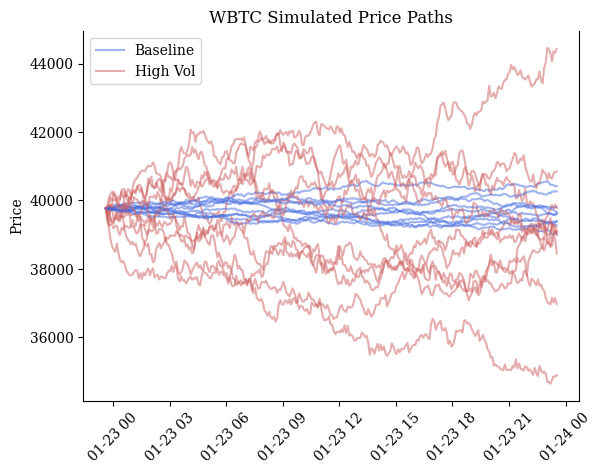

In [5]:
f, ax = plt.subplots()

for i in range(10):
    baseline.generate_pricepaths()
    highvol.generate_pricepaths()
    baseline_label = highvol_label = None
    if i == 0:
        baseline_label = "Baseline"
        highvol_label = "High Vol"
    ax.plot(
        baseline.pricepaths.prices[WBTC],
        color="royalblue",
        alpha=0.5,
        label=baseline_label,
    )
    ax.plot(
        highvol.pricepaths.prices[WBTC],
        color="indianred",
        alpha=0.5,
        label=highvol_label,
    )

ax.legend()
ax.tick_params(axis="x", rotation=45)
ax.set_ylabel("Price")
ax.set_title("WBTC Simulated Price Paths")
print()

# Simple Correlated Merton Jump-Diffusion Process

We tried to enhance our correlated GBM process with stochastic "jumps". These jumps are modeled as a Poisson process (to sample whether they happen at a given timestep). We model 1 Poisson process for the entire collateral market, meaning that if one asset experiences a jump (e.g. ETH), then other assets will also experience a jump. This follows from the fact that many assets being simulated are derivatives of other assets (e.g. wstETH and WETH), and from the fact that BTC and ETH are very correlated.

### Flash Crashes

We find that stochastic jumps do not meaningfully influence the results in our risk model since they occur very infrequently (i.e. a very small percentage of simulations will experience a jump over the course of a day). 

This is because of a fundamental tradeoff when fitting jump processes. To determine the intensity and size of a jump, we need data on previous jumps. This means we need to classify price movements as jumps or not jumps, which we do by setting a (somewhat arbitrary) threshold. We first take the mean and standard deviation of log returns from historical price data. We then assign an arbitrary number of standard deviations as our threshold for a jump, e.g. 10 standard deviations from the mean log return is a jump. If we set this number too high, then we will get very large and infrequent jumps. If we set the number too low, then we'll get very frequent but immaterial jumps. This is due to the intrinsically volatile nature of crypto assets: they have very fat tails.

Intuitively, jumps are a meaningful risk vector we must explore. We "zoom into" the risk presented by jumps by creating a set of stress scenarios that enforce exactly one downward jump in market prices at the half-way point in the simulation. For a 24 hour simulation horizon, this means that at the 12 hour mark all simulations will experience a jump of varying intensities. Before and after the jump, the prices for all simulations behave as correlated GBMs.

We sample the jump intensity from a multivariate log-normal distribution. This allows us to enforce a correlation between the jump intensities of each market.

We enforce that the jump be negative.

In [6]:
def calc_jump_params(sym, data, freq, num_stds, plot=False):
    """
    Compute mu_j and sigma_j from given price data.

    Methodology: threshold detection.
    """
    data = data.copy()
    data["returns"] = data["close"].pct_change()
    data["log_returns"] = np.log1p(data["returns"])
    data = data.dropna()

    std = data["log_returns"].std()
    threshold = data["log_returns"].mean() + num_stds * std

    data.loc[:, "is_jump"] = (
        data["log_returns"].copy() < -threshold
    )  # NOTE only considering negative jumps

    if plot:
        f, ax = plt.subplots()
        ax.plot(data["close"], color="royalblue", lw=2)
        for i, row in data.iterrows():
            if row["is_jump"]:
                ax.axvline(i, color="indianred", linestyle="--", lw=1)
        ax.tick_params(axis="x", rotation=45)
        ax.set_ylabel("Price")
        ax.set_title(f"Detecting {sym} Price Jumps")
        plt.show()

    mu_j = data[data["is_jump"]]["log_returns"].mean()
    sigma_j = data[data["is_jump"]]["log_returns"].std()

    return mu_j, sigma_j


def calc_flash_crash_params(syms, start, freq, num_stds, plot=False):
    """
    Calculate the flash crash parameters for the input coins.
    """
    assert (
        freq == "1h"
    ), "Data is hourly so freq must be hourly! Results are annualized."
    stats = []
    for i, sym in enumerate(syms):
        # Fetch and process data
        df = fetch_all(sym, start, freq)
        mu_j, sigma_j = calc_jump_params(sym, df, freq, num_stds, plot=plot)
        stats.append(
            {
                "symbol": sym,
                "mu_j": round(mu_j, 6),
                "sigma_j": round(sigma_j, 6),
            }
        )
    stats = pd.DataFrame(stats)
    stats.set_index("symbol", inplace=True)
    return stats


def make_flash_crash_params(mu_j_eth, sigma_j_eth, mu_j_btc, sigma_j_btc):
    """
    Make the flash crash params for the given coins.
    """
    # Flash crash config
    coins_j = [WETH, WSTETH, SFRXETH, WBTC, TBTC]

    mu_j = [mu_j_eth, mu_j_eth, mu_j_eth, mu_j_btc, mu_j_btc]
    std_j = [sigma_j_eth, sigma_j_eth, sigma_j_eth, sigma_j_btc, sigma_j_btc]

    # Assume full correlation during jumps
    n = len(coins_j)
    corr_j = np.ones((n, n))

    cov_j = np.outer(std_j, std_j) * corr_j

    return {"type": "flash_crash", "coins_j": coins_j, "mu_j": mu_j, "cov_j": cov_j}

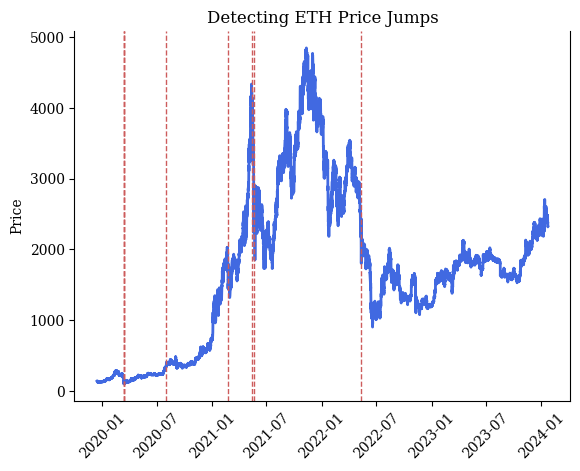

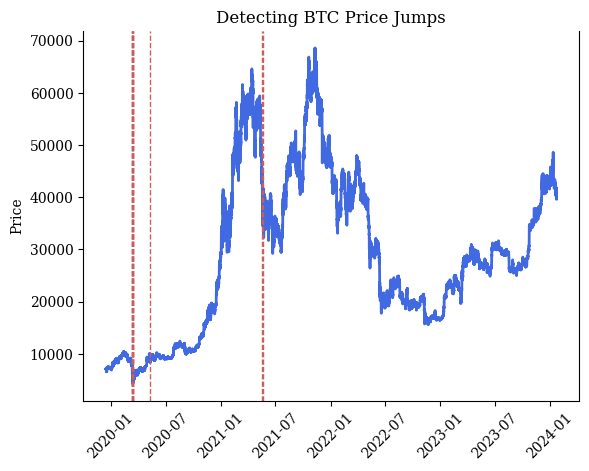

,mu_j,sigma_j
symbol,,
ETH,-0.135027,0.044592
BTC,-0.110504,0.032192


In [7]:
start = int(datetime(2020, 1, 1).timestamp())
freq = "1h"
jump_stats = calc_flash_crash_params(["ETH", "BTC"], start, freq, 10, plot=True)
jump_stats

# Distribution of returns

We have a very fat tailed distribution of hourly log returns.

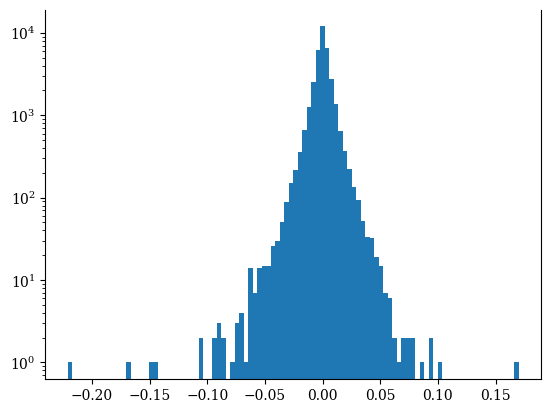

In [8]:
sym = "ETH"
freq = "1h"
df = fetch_all(sym, start, freq)
df["returns"] = df["close"].pct_change()
df["log_returns"] = np.log1p(df["returns"])
df = df.dropna()

f, ax = plt.subplots()
df["log_returns"].hist(bins=100, grid=False, ax=ax)
ax.set_yscale("log")

In [9]:
start = int(datetime(2020, 1, 1).timestamp())
freq = "1h"
jump_stats = calc_flash_crash_params(
    ["ETH", "BTC"], start, freq, num_stds=4, plot=False
)
mu_j_eth, sigma_j_eth = jump_stats.loc["ETH"].to_list()
mu_j_btc, sigma_j_btc = jump_stats.loc["BTC"].to_list()
jump_params = make_flash_crash_params(mu_j_eth, sigma_j_eth, mu_j_btc, sigma_j_btc)
jump_params

{'type': 'flash_crash',
 'coins_j': ['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
  '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0',
  '0xac3e018457b222d93114458476f3e3416abbe38f',
  '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599',
  '0x18084fba666a33d37592fa2633fd49a74dd93a88'],
 'mu_j': [-0.055641, -0.055641, -0.055641, -0.043453, -0.043453],
 'cov_j': array([[0.00061425, 0.00061425, 0.00061425, 0.00050455, 0.00050455],
        [0.00061425, 0.00061425, 0.00061425, 0.00050455, 0.00050455],
        [0.00061425, 0.00061425, 0.00061425, 0.00050455, 0.00050455],
        [0.00050455, 0.00050455, 0.00050455, 0.00041445, 0.00041445],
        [0.00050455, 0.00050455, 0.00050455, 0.00041445, 0.00041445]])}

# Show the Flash Crash Scenario

In [10]:
from src.configs import MODELLED_MARKETS

scenario = Scenario("severe flash crash", MODELLED_MARKETS)

[INFO][18:38:09][src.sim.scenario]-69410: Fetching wbtc market from subgraph
[INFO][18:38:13][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:38:13][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:38:13][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:38:13][src.sim.scenario]-69410: Fetching weth market from subgraph
[INFO][18:38:17][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:38:17][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:38:17][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:38:17][src.sim.scenario]-69410: Fetching sfrxeth market from subgraph
[INFO][18:38:21][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:38:21][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:38:21][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:38:21][src.sim.scenario]-69410: F

/Users/tncintra/Desktop/root/xenophon/clients/curve/crvUSDrisk/src/prices/utils.py:483: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  np.random.multivariate_normal(


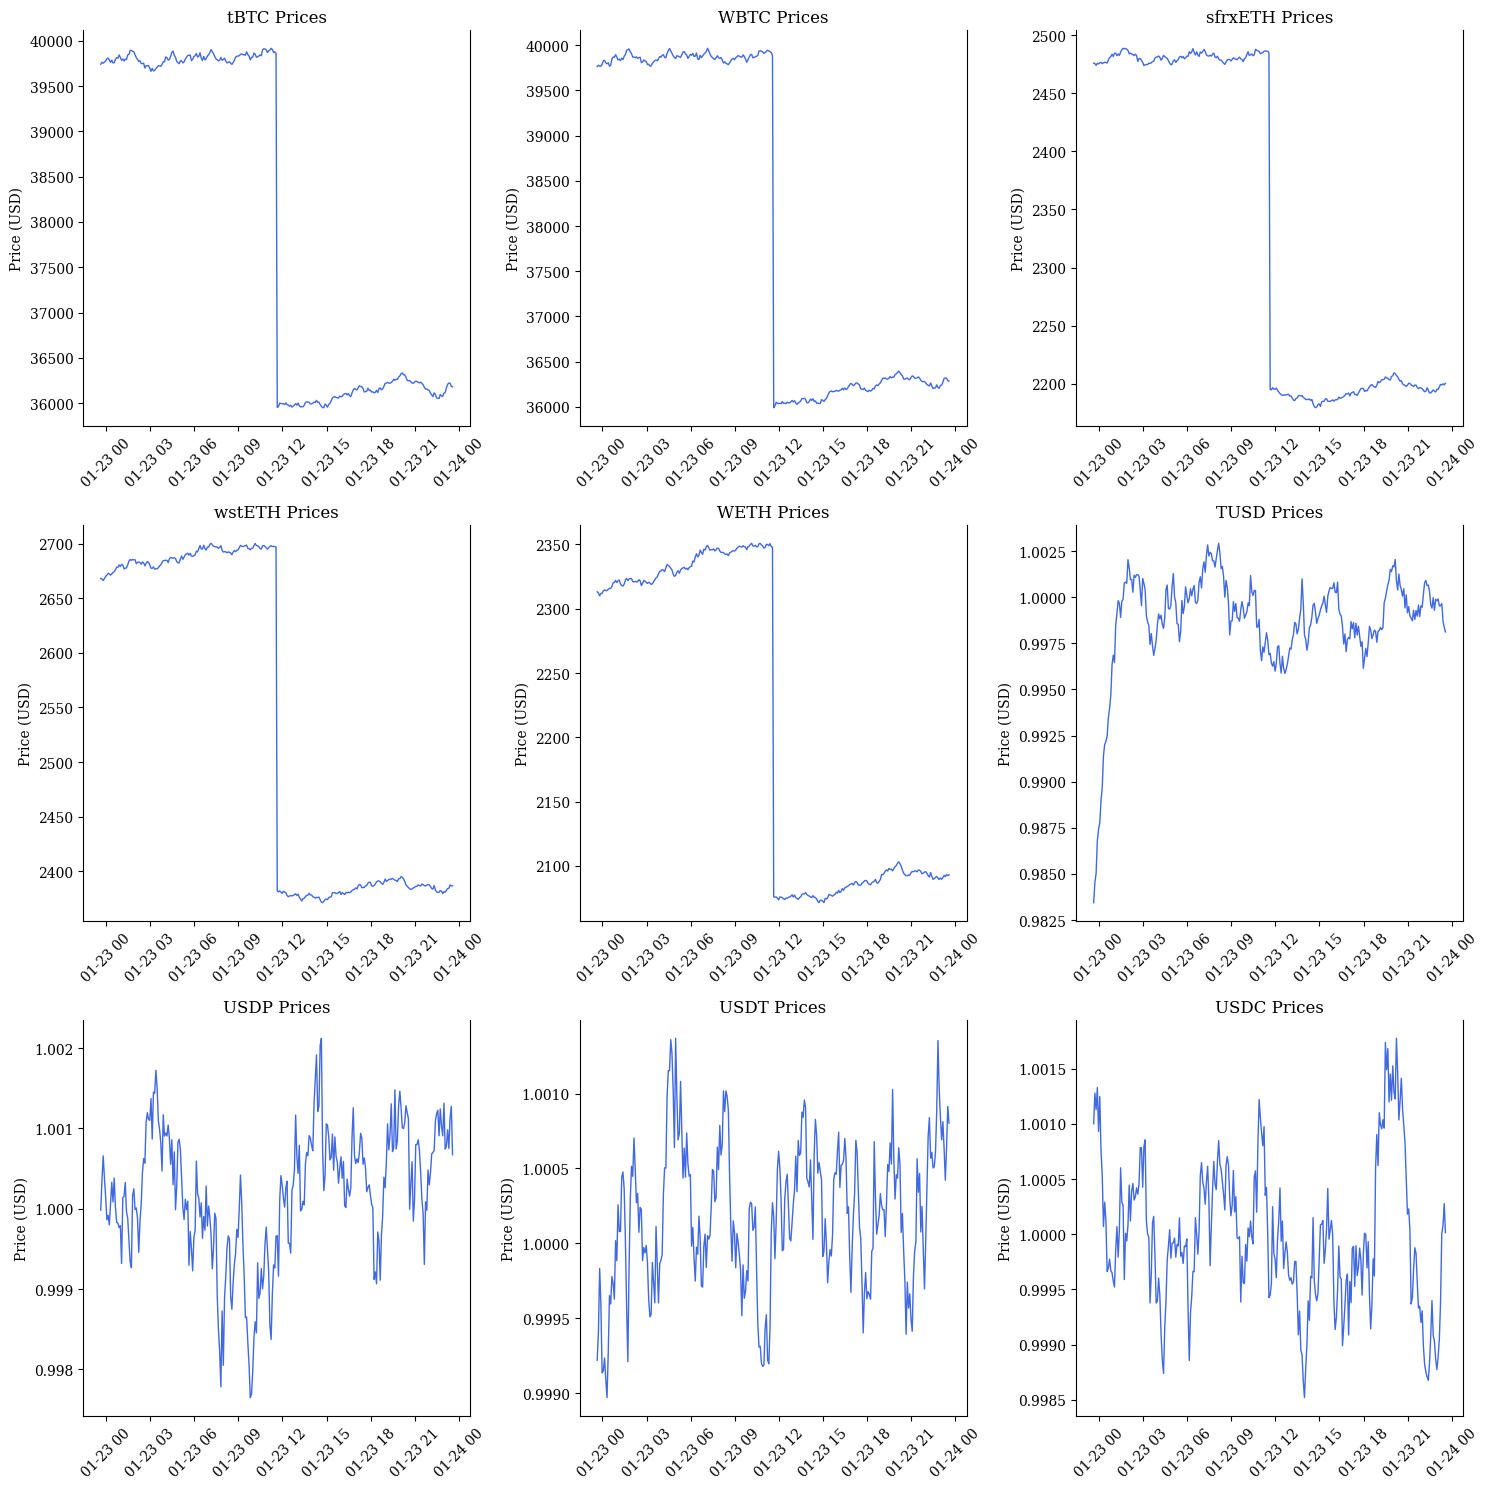

In [11]:
scenario.generate_pricepaths()
_ = plot_prices(scenario.pricepaths.prices)

# Depegs

For the flash crash scenario we simulate a market crash where all collateral prices experience a jump at a pre-determined time. Similarly, the Depeg scenario encodes that exactly one stablecoin (we chose USDC) will experience a depeg while other stablecoins remain unaffected.

Again, we have skirted the "intensity" problem of jumps by simply encoding a scenario where they occur once with a probability of 1. We must still size the intensity of the jump. Given these are stablecoins, this is much easier to do.


### Limitations

1. We do not model the reflexivity between stablecoins. When USDC depegs, it is likely that USDT will experience an opposite depeg upwards as traders rush to sell USDC for USDT. We assume USDT will continue to behave as an OU process and therefore will not necessarily spike up in price following the USDC depeg.
2. We do not assume other stablecoins (TUSD and USDP) will depeg with USDC.

In [13]:
scenario_depeg = Scenario("adverse depeg", MODELLED_MARKETS)

[INFO][18:39:27][src.sim.scenario]-69410: Fetching wbtc market from subgraph
[INFO][18:39:31][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:39:31][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:39:31][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:39:31][src.sim.scenario]-69410: Fetching weth market from subgraph
[INFO][18:39:34][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:39:34][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:39:34][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:39:34][src.sim.scenario]-69410: Fetching sfrxeth market from subgraph
[INFO][18:39:38][src.sim.scenario]-69410: Market snapshot as 2024-01-16 22:24:59
[INFO][18:39:38][src.sim.scenario]-69410: Bands snapshot as 2024-01-15 19:58:47
[INFO][18:39:38][src.sim.scenario]-69410: Users snapshot as 2024-01-16 23:17:47
[INFO][18:39:38][src.sim.scenario]-69410: F

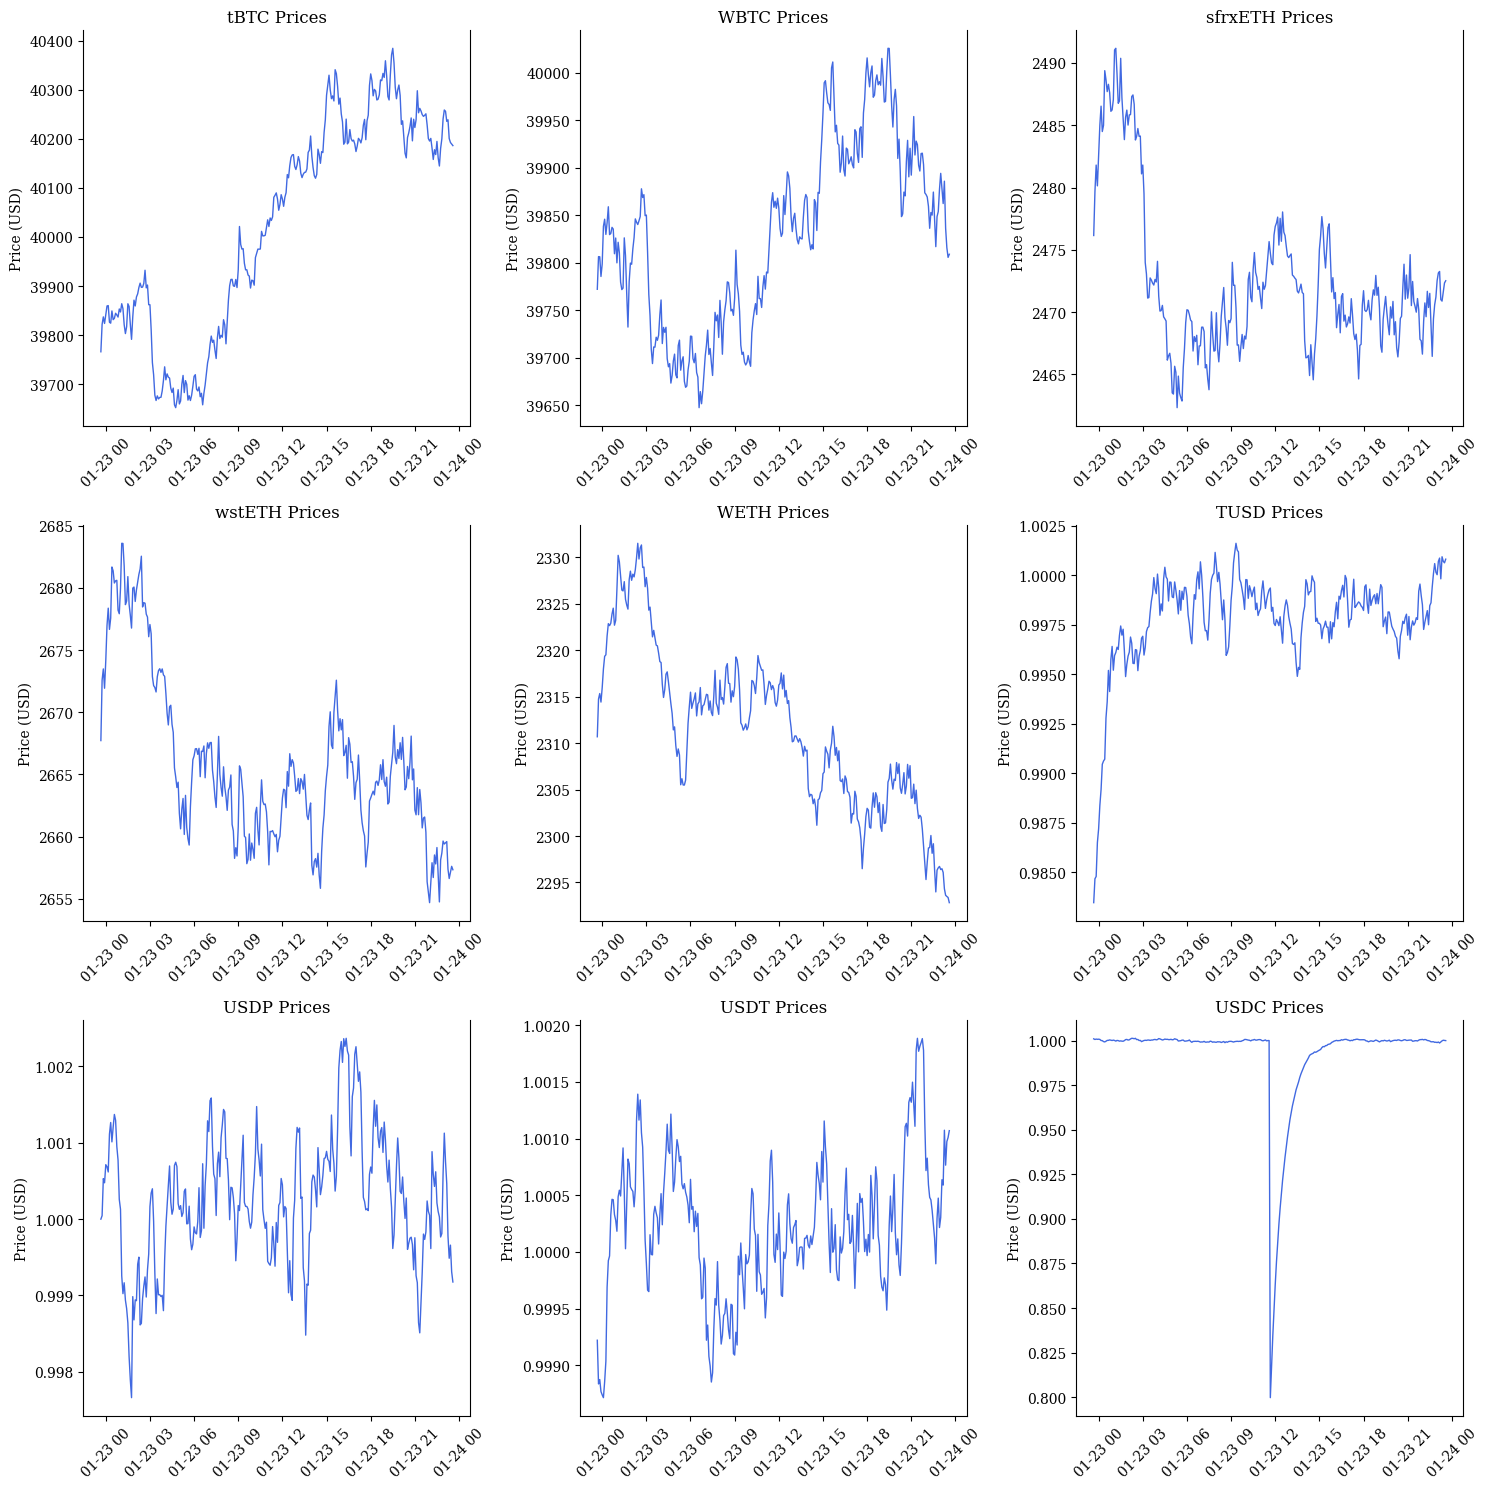

In [14]:
scenario_depeg.generate_pricepaths()
_ = plot_prices(scenario_depeg.pricepaths.prices)